# 1. EDA를 반영한 알고리즘의 핵심 구성  



## 1-1. 질병경중급등급코드(dsas_ltwt_gcd, 이하 ltwt라고 표기)을 기준으로 앙상블 기법 사용

> 1) ltwt 1에 속하는 접수건들과 그외(ltwt 2,3)에 속하는 접수건들을 분리하여 학습

## 1-2. 청구정보(진단, 수술, 입원, 통원)에서 절대적 0과 상대적 0을 구분하는 파생변수 생성

> 1) 접수건 별 병원별평균청구정보, 질병별평균청구정보, 접수건별 청구정보가 0 인 경우에 따라 인덱스 생성

> 2) 접수건 별 병원별평균청구정보, 질병별평균청구정보, 접수건별 청구정보의 순서에 따라 인덱스 생성


## 1-3. 변수추출 및 선택

> 1) 입원일수(hspz_dys_s), 통원횟수(optt_nbtm_s) 학습에서 제외

> 2) 의료기관구분코드(mdct_inu_rclss_dcd)가 9인 경우 학습에서 제외

> 3) 의료기관구분코드(mdct_inu_rclss_dcd)와 요양병원여부(nur_hosp_yn) 변수를 하나로 통합

# 2. 핵심 구성에 반영한 EDA 정보



In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

train_path = r'resources/dataset/insurance/train.csv' 
test_path = r'resources/dataset/insurance/test.csv' 

In [2]:
def load_csv(full_path, index_col = None, usecols = None, dtype = None):

    data  = pd.read_csv(filepath_or_buffer= full_path, index_col = index_col, usecols = usecols, dtype = dtype)

    return data

def make_base(data_path, is_train = True):

    data = load_csv(data_path)

    #cols = make_base_col(data)
    if is_train :
        data['label_2'] = 0
        data.loc[data.target != 0, 'label_2'] = 1

    data = data.drop(columns = ['ID'])
    data = data.rename(columns = {'target' : 'label_3'})

    return data

def cols_dtype(df, target_cols = ['label_3','label_2'], with_label = False):

    conti = df.dtypes.loc[df.dtypes != 'int64'].index.values
    categ = df.dtypes.loc[df.dtypes == 'int64'].index.values
    #Try using .loc[row_indexer,col_indexer] = value instead
    
    if not with_label :
        
        categ = np.setdiff1d(categ, target_cols)
        
    else:
        
        categ = categ

    return conti, categ 

In [3]:
train_df = make_base(train_path, is_train=True)
test_df = make_base(test_path,is_train=False)

conti, cate = cols_dtype(test_df)

## 2-0. 참고사항

> 표기 안내

1. 자동지급은 target 0, 서류 심사는 target 1, 현장 심사는 target 2로 표기한다.
2. 

> 참고 사항
1. 청구정보를 나타내는 변수에서 절대적 0과 상대적 0이 모두 존재한다.
2. 서류 심사와 현장 심사에서는 지급 거절이 될 가능성이 있다.

> 절대적 0의 의미
1.   청구정보가 없다.(본 접수건에서는 해당 치료행위를  하지 않았다.) 
2.   지급거절되었다.
3.   누락되었다.

> 상대적 0의 의미
1. 청구정보 중 절대적 0이상의 최솟값이다.
2. 개인정보보호를 위해 특정 분포로 변이 하였으나, 음의 실수는 존재하지 않으므로, 최솟값으로 해석할 수 있다.

## 2-1. 질병경중급등급코드(dsas_ltwt_gcd, 이하 ltwt라고 표기)을 기준으로 앙상블 기법 사용

> 1) ltwt 1인 경우, 청구보험금이 0인 경우 절대적 0일 가능성이 높지만, 그 외의 경우(ltwt 2,3) 상대적 0일 확률이 높다.

>> ltwt 1인 경우, 질병별평균청구보험금의 분포를 target 1과 2를 나누어 살펴보면, 대체로 0 이상인 반면, 동일하게 접수건 별 청구보험금의 분포를 살펴본 결과, 특히ㅣ target 2에서 0의 빈도값이 높은 것을 볼 수 있다.

>> 반면에 ltwt 2,3인 경우, 질병별평균청구보험금은 target 0,1,2 모두 0을 중심으로 분포되어있지만(이상치 제외), 접수건별 청구보험금의 분포에서 target 2인 경우 각 질병코드 별로 0이 중앙값임을 알 수 있다.

>> 이는 동시에 현장 심사를 하게 되는 경우, 지급이 안되는 경우가 많아 질 수 있음을 의미한다. 

> 2) 동일한 질병구분코드(dsas_acd_rst_dcd, 이하 dsas_rst)이더라도, ltwt가 1인 경우와 아닌 경우의 질병평균청구정보의 분포는 상이하다.

> 3) ltwt 1인 경우, 자동지급은 해당되지 않으므로, 다중분류가 아닌 이진분류 문제로 치환할 수 있다.

In [4]:
class get_figures(object):

    def __init__(self, base_df):
        self.base_df = base_df

    def make_kwargs(self, val_col, by_col, ax=0, rot=90, showfliers=False):

        key_list = ['column','by','ax','showfliers']
        val_list = [val_col, by_col, ax, showfliers]

        return dict(zip(key_list,val_list))

    def get_df_case_1(self, cond_col='dsas_ltwt_gcd', cond_val=1, target_col = 'label_3'):

        dsas_23_df = self.base_df.loc[self.base_df[cond_col] != cond_val]

        return [gb_df for gb_idx, gb_df in list(dsas_23_df.groupby(target_col))]

    def get_df_case_2(self, cond_col='dsas_ltwt_gcd', cond_val=1, target_col = 'label_3'):

        dsas_1_df = self.base_df.loc[self.base_df[cond_col] == cond_val]

        return [gb_df for gb_idx, gb_df in list(dsas_1_df.groupby(target_col))]


    def fig_case_1(self, figsize, kwargs_dict_base = None):
      # 아래 세개짜리는 경중급 2,3인데 타겟 0,1,2

        fig = plt.figure(figsize = figsize)

        ax1=fig.add_subplot(1,3,1)
        ax2=fig.add_subplot(1,3,2)
        ax3=fig.add_subplot(1,3,3)

        i=0
        for target_df,ax in zip(self.get_df_case_1(), (ax1,ax2,ax3)):
            kwargs_dict_base['ax'] = ax
            target_df.boxplot(**kwargs_dict_base)
            ax.title.set_text("[" + kwargs_dict_base['column']+ ", " + kwargs_dict_base['by'] +", dsas_ltwd_gcd : (2, 3) , target : " + str(i) + "]")
            i+=1
        plt.suptitle("Boxplot grouped by [" + kwargs_dict_base['column'] + "," + kwargs_dict_base['by'] +", dsas_ltwt_gcd : 2,3]")

        return fig


    def fig_case_2(self, figsize, kwargs_dict_base = None):
      # 위에 두개짜리는 경중급 1인데 타겟 1,2

        fig = plt.figure(figsize = figsize)
        ax1=fig.add_subplot(1,2,1)
        ax2=fig.add_subplot(1,2,2)

        i = 1
        for target_df,ax in zip(self.get_df_case_2(), (ax1,ax2)):
            kwargs_dict_base['ax'] = ax
            target_df.boxplot(**kwargs_dict_base)
            ax.title.set_text("[" + kwargs_dict_base['column']+ ", " + kwargs_dict_base['by'] +", dsas_ltwd_gcd : 1, target : " + str(i) + "]")
            i += 1
        plt.suptitle("Boxplot grouped by [" + kwargs_dict_base['column'] + "," + kwargs_dict_base['by'] +", dsas_ltwt_gcd : 1]")


        return fig

    def main(self, figsize, val_col, by_col):

        kwargs_dict_base= self.make_kwargs(val_col = val_col, by_col = by_col)

        fig_1 = self.fig_case_2(figsize=figsize, kwargs_dict_base=kwargs_dict_base)

        fig_2 = self.fig_case_1(figsize=figsize,kwargs_dict_base=kwargs_dict_base)


        return fig_1, fig_2

# 위에 두개짜리는 경중급 1인데 타겟 1,2
# 아래 세개짜리는 경중급 2,3인데 타겟 0,1,2

fig_cls = get_figures(train_df)

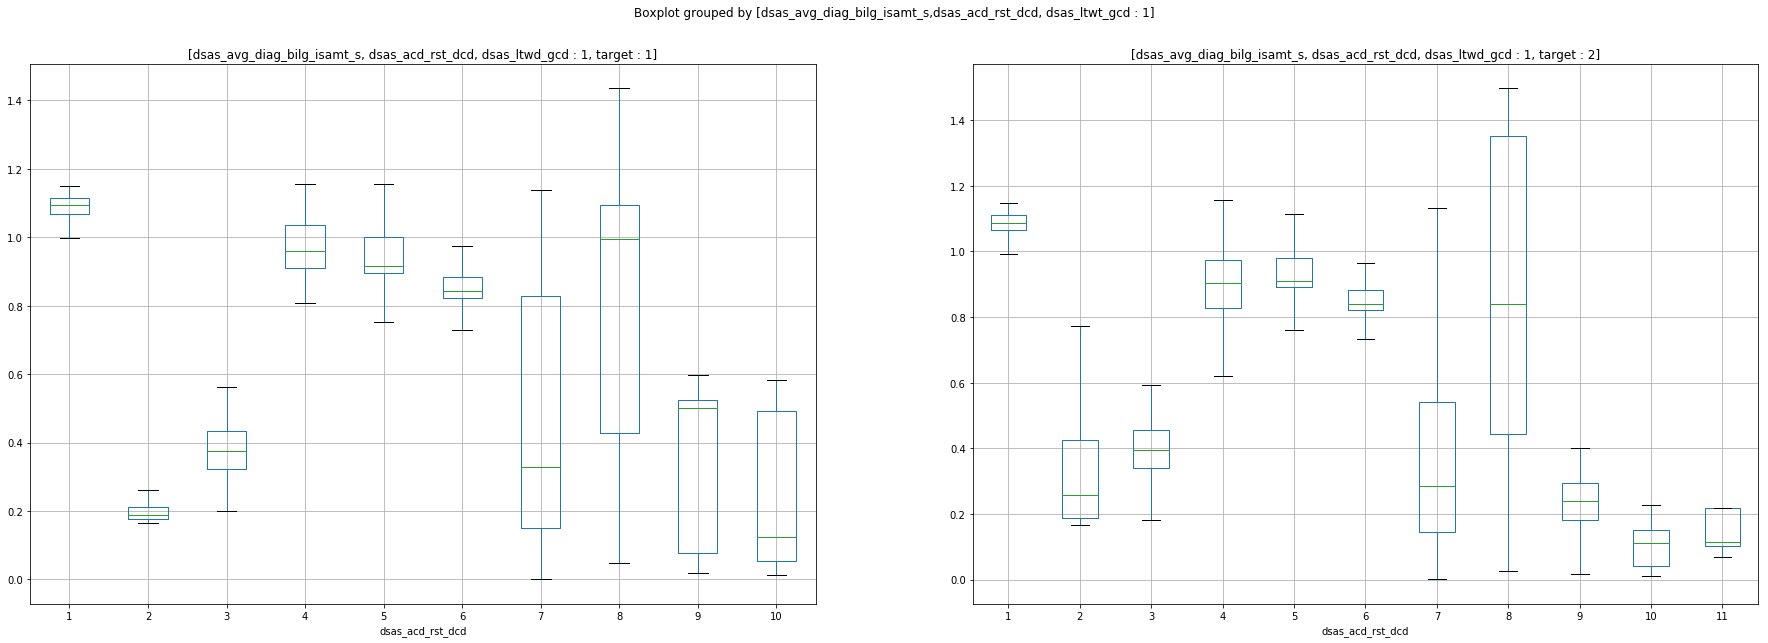

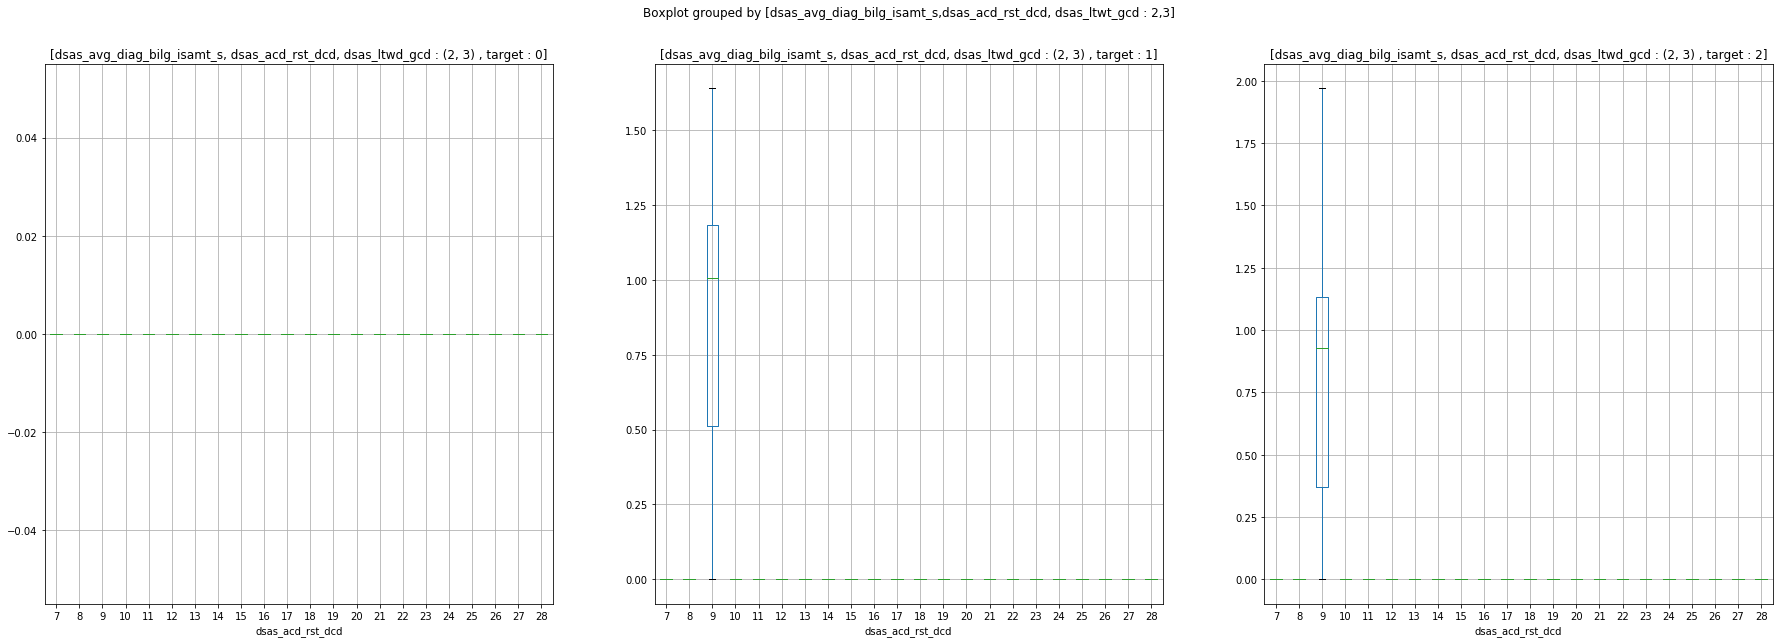

In [5]:
dsas_avg_diag_fig = fig_cls.main(figsize=(30,10),val_col = 'dsas_avg_diag_bilg_isamt_s', by_col = 'dsas_acd_rst_dcd')

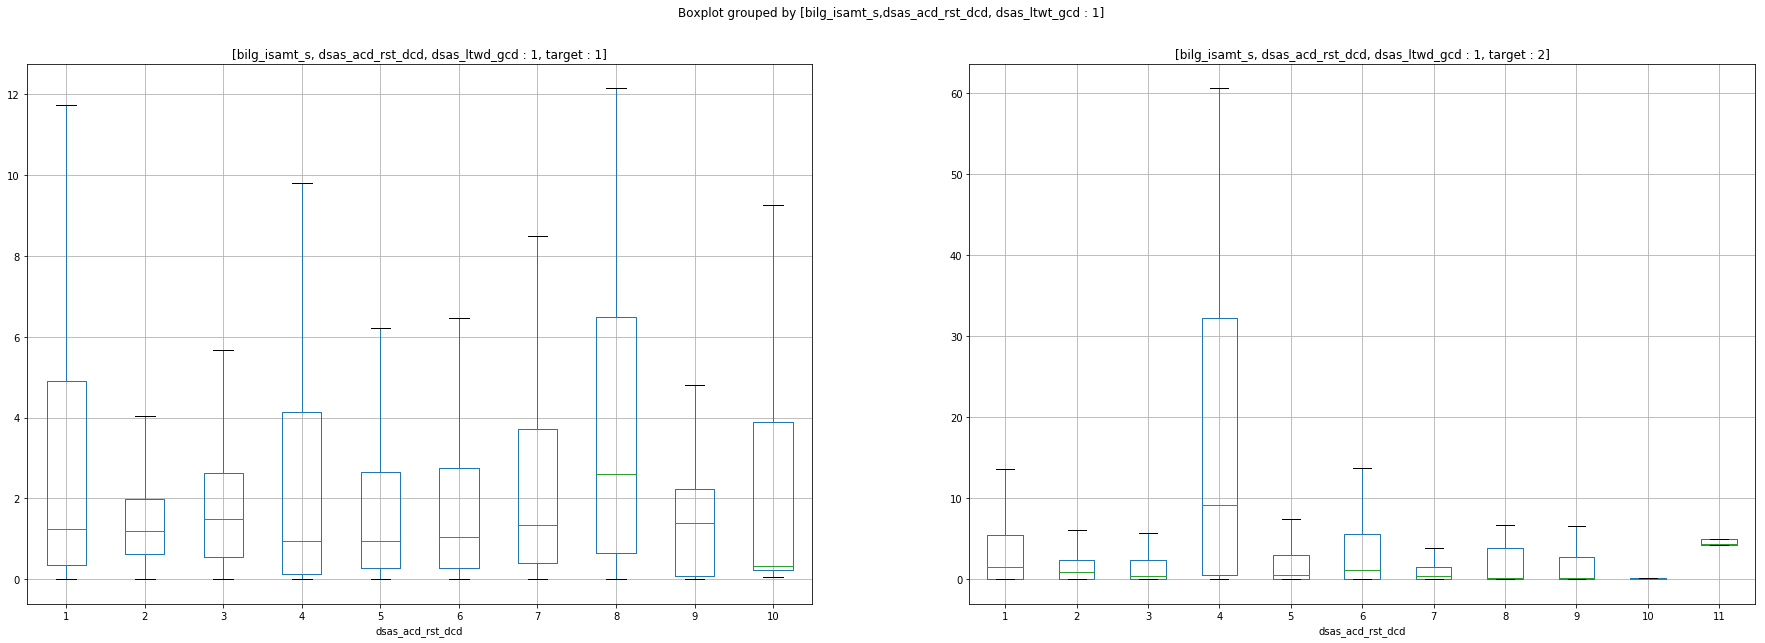

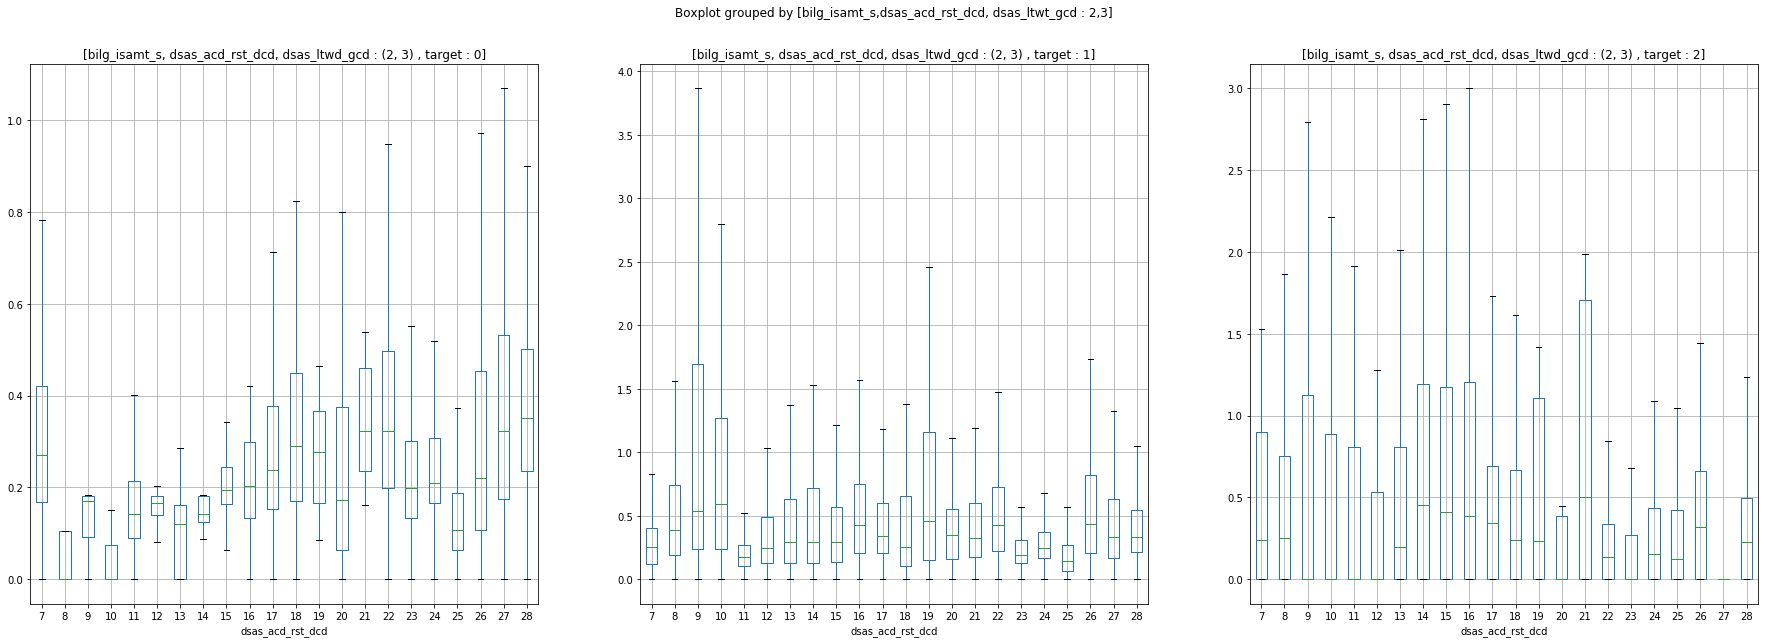

In [6]:
single_diag_fig = fig_cls.main(figsize=(30,10),val_col = 'bilg_isamt_s', by_col = 'dsas_acd_rst_dcd')

Text(0.5, 0.98, 'Group by dsas_ltwt_gcd, dsas_acd_rst_dcd by target')

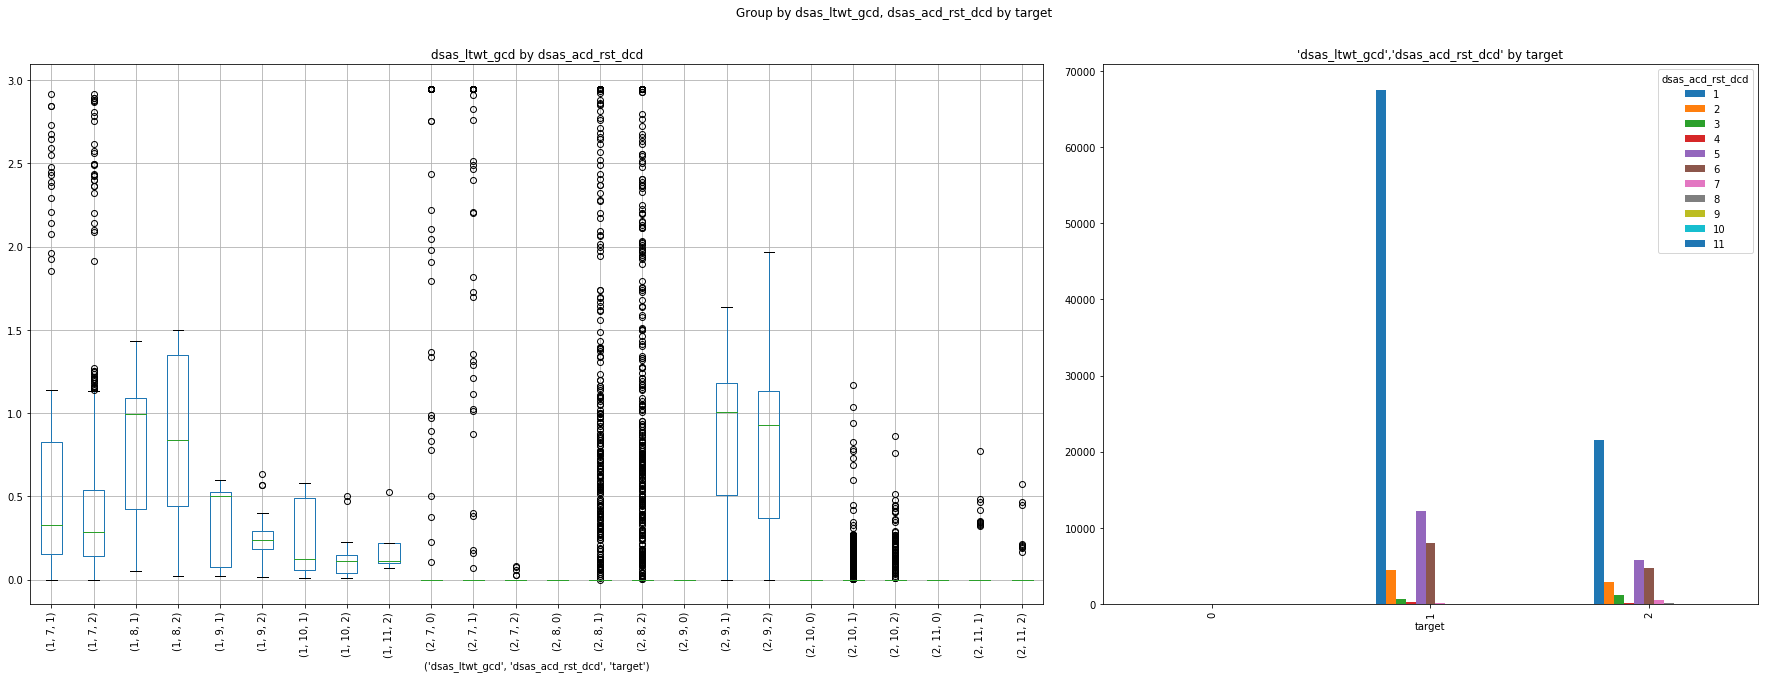

In [7]:
cols_1_1 = ['dsas_ltwt_gcd','dsas_acd_rst_dcd','label_3']

dsas_acd_sub = train_df.loc[train_df['dsas_acd_rst_dcd'].isin([7,8,9,10,11])]

fig = plt.figure(figsize=(30,10))
ax1=fig.add_subplot(1,5,(4,5))
ax2=fig.add_subplot(1,5,(1,3))

train_df[cols_1_1].groupby(cols_1_1).size().unstack().fillna(0).loc[1].T.plot.bar(ax=ax1) 
dsas_acd_sub.boxplot(column = 'dsas_avg_diag_bilg_isamt_s',by = cols_1_1,ax=ax2,rot=90,showfliers=True)

ax1.title.set_text("'dsas_ltwt_gcd','dsas_acd_rst_dcd' by target")
ax1.set_xlabel("target")

ax2.title.set_text("dsas_ltwt_gcd by dsas_acd_rst_dcd")
ax2.set_xlabel("('dsas_ltwt_gcd', 'dsas_acd_rst_dcd', 'target')")

plt.suptitle("Group by dsas_ltwt_gcd, dsas_acd_rst_dcd by target")

##2-2 청구정보(진단, 수술, 입원, 통원)에서 절대적 0과 상대적 0을 구분하는 파생변수 생성

> 1) 청구정보성격(병원별평균청구, 질병별평균청구, 개별청구)별 0의 분포가 다르다.

> 2) 질병구분별 0의 분포가 다르다. 

### 주요 변수별 연속형 0 

### 연속형 변수 - 타겟 별 0

In [8]:
train_condi_zero = train_df[list(conti) + ['label_3']]

In [9]:
for i in conti:
  print("columns : ",i)
  # print(train_condi_zero[train_condi_zero[i]==0][[i,'label_3']])
  print(train_condi_zero[train_condi_zero[i]==0][[i,'label_3']].groupby('label_3').count())
  print("\n")

columns :  hsp_avg_optt_bilg_isamt_s
         hsp_avg_optt_bilg_isamt_s
label_3                           
0                            54689
1                            93186
2                            20710


columns :  hsp_avg_surop_bilg_isamt_s
         hsp_avg_surop_bilg_isamt_s
label_3                            
0                              4955
1                             28850
2                             10204


columns :  hspz_dys_s
         hspz_dys_s
label_3            
0             48968
1             67395
2             18721


columns :  hsp_avg_diag_bilg_isamt_s
         hsp_avg_diag_bilg_isamt_s
label_3                           
0                            62432
1                           107236
2                            21198


columns :  dsas_avg_diag_bilg_isamt_s
         dsas_avg_diag_bilg_isamt_s
label_3                            
0                             93733
1                            128394
2                             19558


columns 

### 연속형 변수 - 질병구분코드 별 0

In [10]:
train_dsas_acd_zero = train_df[list(conti) + ['dsas_acd_rst_dcd']]

In [11]:
for i in conti:
  print("columns : ",i)
  # print(train_dsas_acd_zero[train_dsas_acd_zero[i]==0][[i,'dsas_acd_rst_dcd']])
  print(train_dsas_acd_zero[train_dsas_acd_zero[i]==0][[i,'dsas_acd_rst_dcd']].groupby('dsas_acd_rst_dcd').count())
  print("\n")

columns :  hsp_avg_optt_bilg_isamt_s
                  hsp_avg_optt_bilg_isamt_s
dsas_acd_rst_dcd                           
1                                     19054
2                                      1385
3                                       415
4                                        95
5                                      4137
6                                      5587
7                                       911
8                                      1954
9                                      1123
10                                     1575
11                                     8829
12                                     1319
13                                      788
14                                      188
15                                     1307
16                                     4503
17                                    20897
18                                       91
19                                       84
20                                     

                  surop_blcnt_s
dsas_acd_rst_dcd               
1                         49350
2                          2112
3                           723
4                           222
5                          8646
6                         10127
7                          2862
8                          4924
9                          1830
10                          959
11                        16031
12                         2047
13                         1116
14                          390
15                         2134
16                         6872
17                        21912
18                          112
19                           81
20                           82
21                          394
22                          110
23                         1534
24                          479
25                         3687
26                         2129
27                         1562
28                         2691


columns :  dsas_avg_optt_bilg_isamt_s


In [12]:
  def get_q_range(q_d):

    base_point = 10 ** (-1*q_d)

    return np.arange(base_point, 1+base_point, base_point)

  def get_single_quantile(base_df, col,q_d):
    '''
    q is quantile
    '''

    return base_df[col].quantile(get_q_range(q_d))

## 2-3 훈련 데이터와 테스트 데이터 병원종류 차이에 따른 라벨링 수정

> 1) 훈련 데이터에는 의료기관구분코드가 1부터 9까지 존재하나, 테스트 데이터에는 의료기관구분코드가 1부터 3까지 존재한다. 이에 따른 전처리가 필요하다   

>> 훈련 데이터에서도 대부분의 데이터가 1-3 사이에 위치하고 있으며, 9의 경우가 많지 않는다.
>> 테스트 데이터에서 없는 범주를 훈련하게 될 경우 모델의 학습시간 증가 및 복잡도 증가를 유발할 수 있다.

> 2) 이에 따라서 학습하기 전에 훈련 데이터에서 의료기관구분코드가 9일 경우 해당 데이터를 제거했다.   

> 3) 기존의 377928개의 데이터를 377735개로 줄이게 됨에 따라 전체 데이터에 큰 영향을 미치지 않고 이상치를 제거하여 학습할 수 있다.   

In [13]:
train_df.groupby(['mdct_inu_rclss_dcd','nur_hosp_yn']).size().unstack().fillna(0)

nur_hosp_yn,0,1
mdct_inu_rclss_dcd,,
1,29989.0,70945.0
2,190627.0,17209.0
3,68965.0,0.0
9,192.0,1.0


In [14]:
test_df.groupby(['mdct_inu_rclss_dcd','nur_hosp_yn']).size().unstack().fillna(0)

nur_hosp_yn,0,1
mdct_inu_rclss_dcd,,
1,1600.0,5066.0
2,10814.0,907.0
3,3685.0,0.0
